# Credit Card Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

An autoencoder is used as an unsupervised model to identify irregularities that might indicate fraud. It is imperfect, but works reasonable well.

The data is available on [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Read Data

The original data set is fairly large. To reduce experiment cycle time, a subset of of the data is used here.

In [2]:
#data = pd.read_csv("data/creditcard.csv")
#data = data.head(30000)
#data.shape

In [3]:
#data.to_csv('data/subset.csv', index=False)

In [4]:
data = pd.read_csv("data/subset.csv")
data.shape

(30000, 31)

## Data Engineering

The Time column is ignored and the Amount is normalized. All other columns remain the same.

In [5]:
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [6]:
X_train, X_test = train_test_split(data, test_size=0.2)
#X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(24000, 29)

## Autoencoder Model

This is a standard dense autoencoder with four layers.

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
nb_epoch = 40
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

autoencoder = load_model('model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 24000 samples, validate on 6000 samples
Epoch 1/40
24000/24000 [==============================] - 1s 31us/step - loss: 1.1338 - acc: 0.3640 - val_loss: 1.0480 - val_acc: 0.4710
Epoch 2/40
24000/24000 [==============================] - ETA: 0s - loss: 1.0214 - acc: 0.522 - 1s 27us/step - loss: 1.0214 - acc: 0.5255 - val_loss: 0.9844 - val_acc: 0.5645
Epoch 3/40
24000/24000 [==============================] - 1s 27us/step - loss: 0.9796 - acc: 0.5774 - val_loss: 0.9558 - val_acc: 0.5913
Epoch 4/40
24000/24000 [==============================] - 1s 28us/step - loss: 0.9594 - acc: 0.5845 - val_loss: 0.9410 - val_acc: 0.5898
Epoch 5/40
24000/24000 [==============================] - 1s 26us/step - loss: 0.9474 - acc: 0.5818 - val_loss: 0.9316 - val_acc: 0.5787
Epoch 6/40
24000/24000 [==============================] - 1s 27us/step - loss: 0.9384 - acc: 0.5775 - val_loss: 0.9205 - val_acc: 0.5838
Epoch 7/40
24000/24000 [===================

## Model Performance

A simple plot of model accuracy to confirm that is learning something.

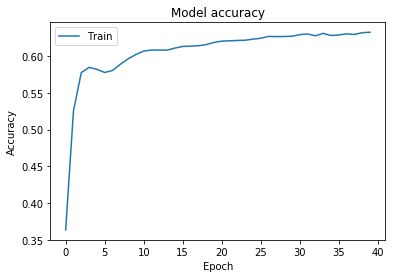

In [9]:
# summarize history for accuracy
plt.plot(history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## Prediction

Predictions are made on the test set. The mean-squared error (MSE) is calculated between the test set and their predictions. If the MSE is high, it's a potential irregularity that might suggest fraud. It's not perfect, there will be false positives and false negatives.

In [10]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

## Plot Reconstruction Error

The reconstruction error for each sample is plotted long with a color code indicating known fraud. Only 6000 samples are plotted, but the index is randomly sampled from the original set, so the X-axis shows almost the full range of indices.

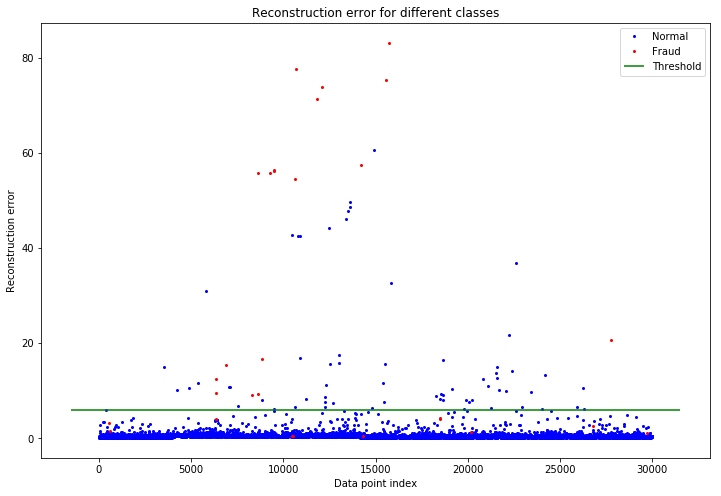

In [13]:
threshold = 6.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Confusion Matrix

The confusion matrix below shows the number of true/false positive/negatives. It's not perfect, but not too bad either.

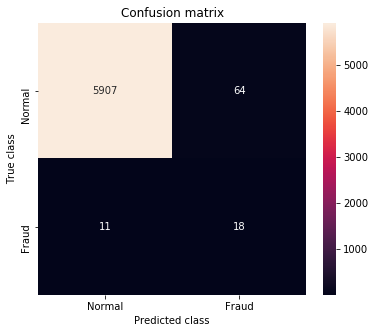

In [14]:
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()